In [1]:
import torch
import torchvision
import torchaudio 
import os
import torch.nn as nn
from os.path import isfile, join, isdir, exists
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
class MusicDataset(Dataset):

    def __init__(self, spec_dir, out_dir, years):
        self.spec_dir = spec_dir
        self.out_dir = out_dir
        self.ims = []
        self.labels = []
        self.names = []

        for dirs in years:
            for f in os.listdir(join(spec_dir, dirs)):
                if(isfile(join(join(out_dir, dirs), f))):
                    self.ims.append(join(join(spec_dir, dirs), f))
                    onm = join(out_dir, dirs)
                    self.labels.append(join(onm, f))
                    self.names.append(join(join(out_dir, dirs), f))
                    #print(join(join(spec_dir, dirs), f))
                    #print(join(onm, f))

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        #print(self.ims[idx])
        im, lab = torch.load(self.ims[idx]), torch.load(self.labels[idx])
        if(im.isnan().any()):
            print(self.names[idx])
        mean = torch.mean(im)
        std = torch.std(im)
        if(std==0):
            im = torch.zeros_like(im)
        else:
            im = (im-mean)/(std)

        if(im.isnan().any()):
            print(self.names[idx], "post", mean, std)
            im = torch.zeros_like(im)

        return im.T, lab.T

bs = 2
training_data = MusicDataset('mel/', 'mid/', ['2004', '2006', '2008', '2009', '2011', '2013', '2014'])
test_data = MusicDataset('mel/', 'mid/', ['2015', '2017', '2018'])
train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True, )
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [3]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Model(nn.Module):

    def __init__(self, ninp:int, ntoken: int, dim_ff: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.enc = torch.nn.Linear(ninp, dim_ff)

        self.pe = PositionalEncoding(dim_ff, dropout)
        self.onc = torch.nn.Linear(ntoken, dim_ff)
        self.lin = torch.nn.Linear(dim_ff, ntoken)
        self.transformer = torch.nn.Transformer(dim_ff, nhead, nlayers, 1, dim_ff, dropout, batch_first=True)


    def forward(self, src: Tensor, tgt, tgt_mask) -> Tensor:

        # print(src.shape, tgt.shape, tgt_mask.shape)
        src = self.enc(src)
        src = self.pe(src)
        # print(tgt.shape, torch.mean(tgt, axis=2))
        tg = torch.roll(tgt, 1, 1)
        tg[:, 0:1, :]*=0
        # print(tg.shape, torch.mean(tg, axis=2))

        tg = self.onc(tgt)
        tg = self.pe(tg)
        
        if(tgt_mask != None):
            src = self.transformer(src, tg, tgt_mask=tgt_mask)
        else:
            src = self.transformer(src, tg)
        output = self.lin(src)
        return nn.Sigmoid()(output)

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

def loss_func(x, y):
    # metric = nn.BCELoss()
    # return metric(x.flatten(), (y.flatten()))
    x = torch.clip(x, min=1e-20, max=1-1e-20)
    if(x.isnan().any()):
        print("ANSH IS A GOON!")
    #return torch.mean(y*torch.log(x)*0.95 + (-1*y+1)*torch.log(-1*x+1)*0.05)*-1
    return torch.mean(y*torch.log(x) + (-1*y+1)*torch.log(-1*x+1))*-1

In [4]:
ntokens = 88 
ninp = 229
emsize = 200  
dff = 200  
nlayers = 3  
nhead = 2  
dropout = 0.2  


In [5]:
model = Model(ninp, ntokens, emsize, nhead, dff, nlayers, dropout).to('cuda')
lr = 3e-5
optim = torch.optim.Adam(lr = lr, params = model.parameters())
save_epochs = 1
val_print_ep = 5
n_epochs = 100
losses = []
for i in range(n_epochs):
    print("starting epoch", i)
    total_loss = 0
    batch = 0
    intlosses = []
    for X, y in train_dataloader:
        print("batch progress", batch, len(train_dataloader))
        batch += 1
        if(batch % 30 == 0):
            torch.save({
            'epoch': i,
            'batch': batch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': intlosses,
            }, 'transformer_intermediate' + str(batch) + '.pt')
        
        # X = torch.unsqueeze(X, axis = 1)
        # print(X.shape)
        X = X.to('cuda')
        # print(X.shape)
        if(X.isnan().any()):
            print("HI")
        # print(X.shape)
        y = y.type(torch.float32).to('cuda')
        tgtmask = generate_square_subsequent_mask(7680).to('cuda')
        
        pred = model(X, torch.zeros_like(y), tgtmask)
        optim.zero_grad()
        loss = loss_func(pred, y)
        intlosses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optim.step()
        total_loss+= np.mean(loss.item())
        print(np.mean(loss.item()))

    loss.append(total_loss)
    print(total_loss)
    if (i % save_epochs == 0):
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses,
            }, 'transformer_saved_data.pt')

    if (i % val_print_ep == 0):
        with torch.no_grad():
            total_loss = 0
            for X, y in test_dataloader:
                X = torch.unsqueeze(X, axis = 1)
                X = X.to('cuda')
                y = y.to('cuda')
                pred = model(X)
                loss = loss_func(y, pred)
                total_loss += loss
        print("Test error after epoch " + str(i) + ": " + str(total_loss/len(test_dataloader)))


starting epoch 0
batch progress 0 25171
0.7319185733795166
batch progress 1 25171
0.7189410328865051
batch progress 2 25171
0.7123223543167114
batch progress 3 25171
0.6962863802909851
batch progress 4 25171
0.6874816417694092
batch progress 5 25171
0.682720422744751
batch progress 6 25171
0.667435884475708
batch progress 7 25171
0.6592485308647156
batch progress 8 25171
0.6495901942253113
batch progress 9 25171
0.6405553817749023
batch progress 10 25171
0.6262503862380981
batch progress 11 25171
0.6328979134559631
batch progress 12 25171
0.6125849485397339
batch progress 13 25171
0.6105905771255493
batch progress 14 25171
0.6055269241333008
batch progress 15 25171
0.595180869102478
batch progress 16 25171
0.5923424959182739
batch progress 17 25171
0.5866571664810181
batch progress 18 25171
0.578107476234436
batch progress 19 25171
0.5708223581314087
batch progress 20 25171
0.5698053240776062
batch progress 21 25171
0.5604179501533508
batch progress 22 25171
0.5584594011306763
batch pr

KeyboardInterrupt: 

In [6]:

tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model(ninp, ntokens, emsize, nhead, dff, nlayers, dropout).to('cuda')
checkpoint = torch.load('transformer_intermediate9150.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.eval()
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname)
X = (X-torch.mean(X))/torch.std(X)
X = X.T
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)
X = X.to('cuda')
y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))
print(X.shape)
with torch.no_grad():
    tgtmask = generate_square_subsequent_mask(7680).to('cuda')
    pred = meval(X, torch.zeros((1, y.shape[1], y.shape[0])).to('cuda'), tgtmask)

# pred_old = torch.ones((1, 1, 88)).to('cuda')
# with torch.no_grad():
#     for i in range(768):                
#         m = generate_square_subsequent_mask(i+1).to('cuda')
#         print(X.shape, pred_old.shape)
#         pred = meval(X, pred_old, m)
#         print(pred.shape)
#         pred_old = torch.concat((torch.zeros((1, 1, 88)).to('cuda'), pred), axis=1)
    #print(nn.BCELoss()(pred[0, :, :], y))


torch.Size([1, 1001, 229])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 7680, 88]) torch.Size([88, 7680])
tensor(0.1183)
tensor(0.2616)


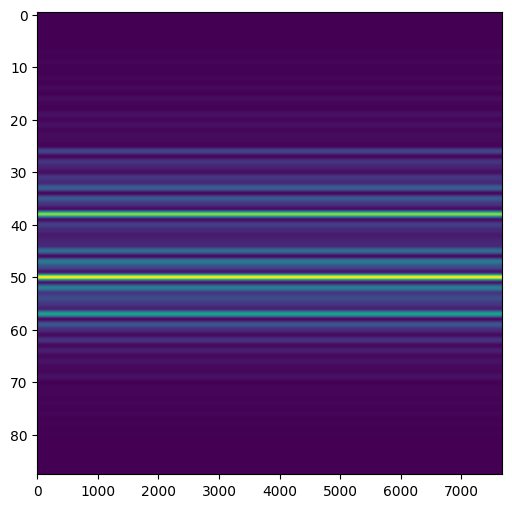

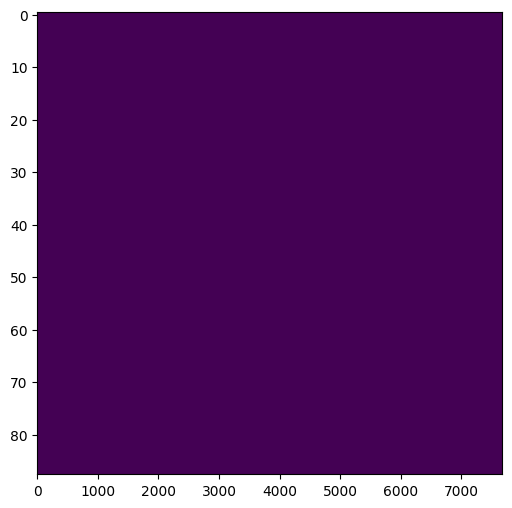

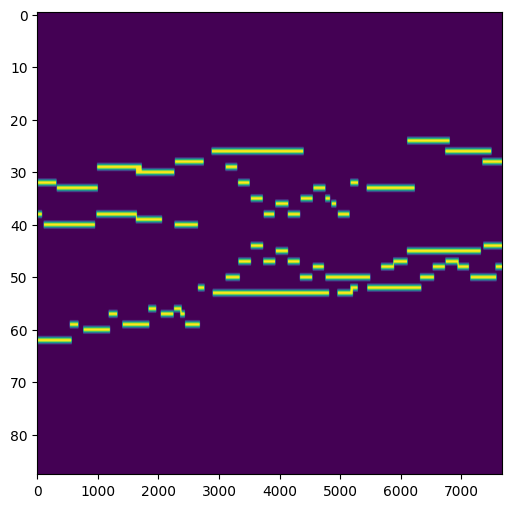

In [7]:

pred = pred.to('cpu')
y = y.to('cpu')

print(np.round(pred))


print(pred.shape, y.shape)
print(loss_func(pred[0, :, :].T, y))

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :].T, aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :].T), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
        
print(torch.max(pred))
lll = [0.4915196895599365, 0.394779771566391, 0.2694735825061798, 0.17687253654003143, 0.09298969060182571, 0.05821599066257477, 0.0368744395673275, 0.0269914623349905, 0.023477263748645782, 0.024886222556233406]

In [ ]:
x = torch.randn((1, 5, 2))
print(x)
y = torch.roll(x, 1, 1)
y[:, 0, :]*=0
print(y)

tensor([[[ 0.1722,  0.6716],
         [-0.0234, -0.3879],
         [-2.7081,  0.5167],
         [ 1.7776, -1.8207],
         [-1.3618, -0.1417]]])
tensor([[[-0.0000, -0.0000],
         [ 0.1722,  0.6716],
         [-0.0234, -0.3879],
         [-2.7081,  0.5167],
         [ 1.7776, -1.8207]]])
